In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%config InlineBackend.figure_format = 'retina'
import numpy as np
import scipy.spatial as ss

In [2]:
def marsaglia(n_points, r=1.):  # Refs: Marsaglia, G., Ann. Math. Stat. 43:645-646, 1972
    assert r > 0, 'radius must be a positive number'
    a = np.random.uniform(-r, r, size=n_points)
    b = np.random.uniform(-r, r, size=n_points)

    mask = np.where(a ** 2 + b ** 2 < 1)
    a = a[mask]
    b = b[mask]

    x = 2 * a * np.sqrt(1 - a ** 2 - b ** 2)
    y = 2 * b * np.sqrt(1 - a ** 2 - b ** 2)
    z = 1 - 2 * (a ** 2 + b ** 2)
    return np.stack((x, y, z), axis=-1)

def estimate_normals(xyz, take_every=1, knn=30, fast=True):
    import open3d as o3d
    xyz = xyz[::take_every, :]
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn),
                         fast_normal_computation=fast)
    pcd.normalize_normals()
    pcd.orient_normals_consistent_tangent_plane(30)
    n = np.asarray(pcd.normals)
    return n


def normals_to_rgb(n):  # RGB-cube
    if n.shape[1] != 3:
        raise ValueError('`n` should be a 3-dimensional vector.')
    n = np.divide(
        n, np.tile(
            np.expand_dims(
                np.sqrt(np.sum(np.square(n), axis=1)), axis=1), [1, 3]))
    rgb = 127.5 + 127.5 * n
    return rgb / 255.0

def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

In [3]:
# generate random point cloud
r = 1
xyz = marsaglia(1000, r)

# create convex hull and extract the surface area
hull = ss.ConvexHull(xyz)
A_hull = hull.area
print(f'A = {A_hull:.6f}')

A = 12.466756


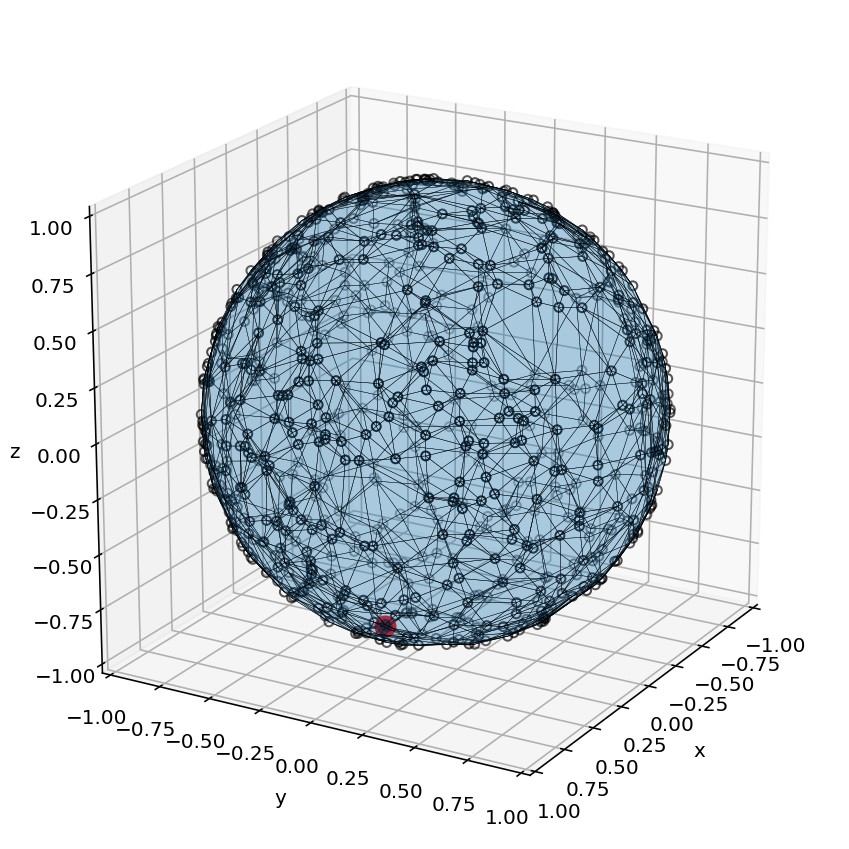

In [4]:
query_point = xyz[0].T

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(*xyz.T, ec='k', c='None')
ax.plot(*query_point, 'ro', markersize=10)
hull_triangle_coords = hull.points[hull.simplices]
triangles = Poly3DCollection(hull_triangle_coords, ec='k', lw=0.2, alpha=0.2)
ax.add_collection3d(triangles)
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1))
ax.view_init(20, 30)
ax.set_box_aspect([1, 1, 1])
ax = set_axes_equal(ax)
fig.tight_layout();

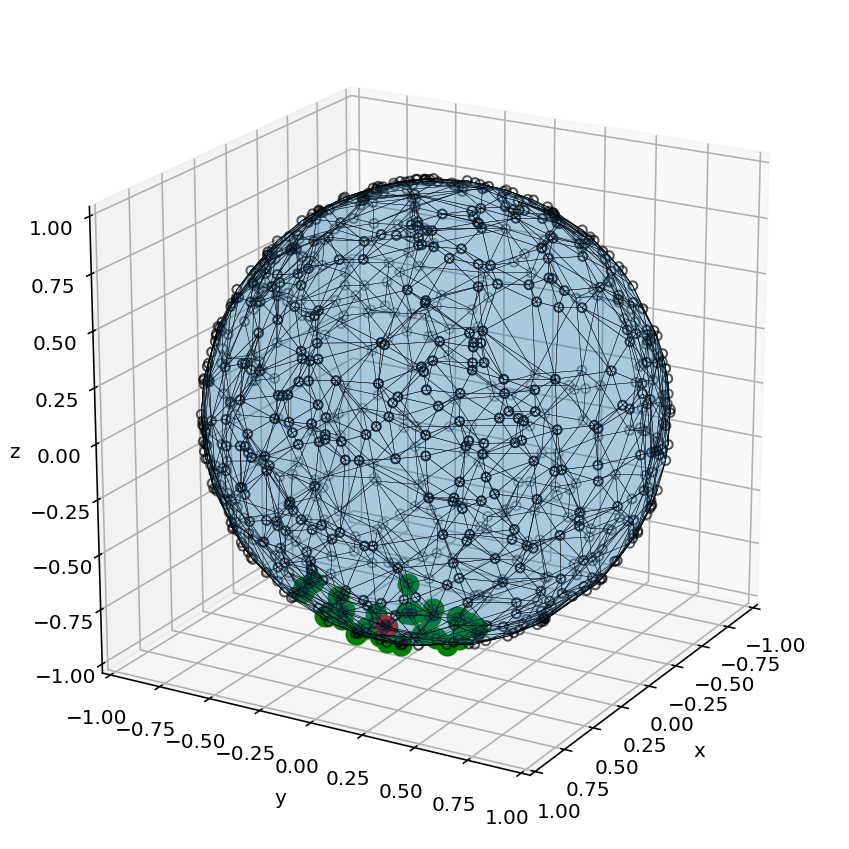

In [5]:
tree = ss.KDTree(xyz)
nbh_dist, nbh_idx = tree.query([query_point], k=33)
query_nbh = xyz[nbh_idx[0]].T

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(*xyz.T, ec='k', c='None')
ax.plot(*query_nbh, 'go', markersize=10)
ax.plot(*query_point, 'ro', markersize=10)
hull_triangle_coords = hull.points[hull.simplices]
triangles = Poly3DCollection(hull_triangle_coords, ec='k', lw=0.2, alpha=0.2)
ax.add_collection3d(triangles)
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1))
ax.view_init(20, 30)
ax.set_box_aspect([1, 1, 1])
ax = set_axes_equal(ax)
fig.tight_layout();

In [6]:
X = query_nbh.T.copy()
X = X - X.mean(axis=0)
C = X.T @ X
U, S, VT = np.linalg.svd(C)
n_idx = np.where(S == S.min())[0][0]
n = U[n_idx]

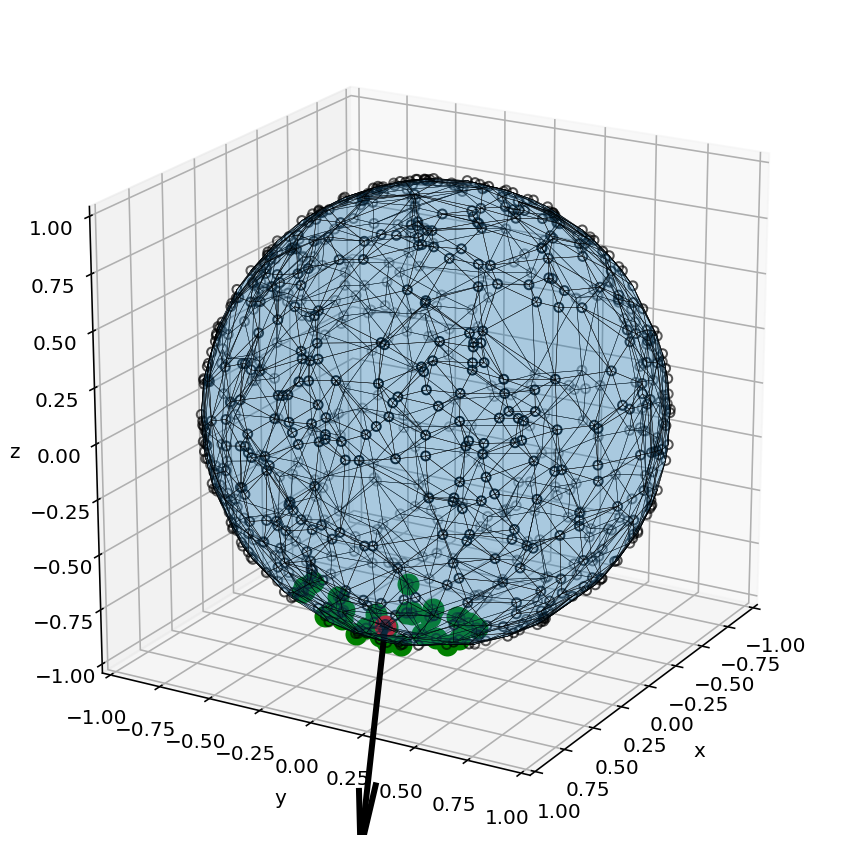

In [7]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(*xyz.T, ec='k', c='None')
ax.plot(*query_nbh, 'go', markersize=10)
ax.plot(*query_point, 'ro', markersize=10)
ax.quiver(*query_point, *-n[:3].T, length=1, lw=3, color='k')
hull_triangle_coords = hull.points[hull.simplices]
triangles = Poly3DCollection(hull_triangle_coords, ec='k', lw=0.2, alpha=0.2)
ax.add_collection3d(triangles)
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1))
ax.view_init(20, 30)
ax.set_box_aspect([1, 1, 1])
ax = set_axes_equal(ax)
fig.tight_layout();

In [8]:
n = np.empty_like(xyz)
for i, query_point in enumerate(xyz):
    nbh_dist, nbh_idx = tree.query([query_point], k=10)
    query_nbh = xyz[nbh_idx[0]].T 
    X = query_nbh.T.copy()
    X = X - X.mean(axis=0)
    C = X.T @ X
    U, S, VT = np.linalg.svd(C)
    n_idx = np.where(S == S.min())[0][0]
    n[i, :] = U[n_idx]

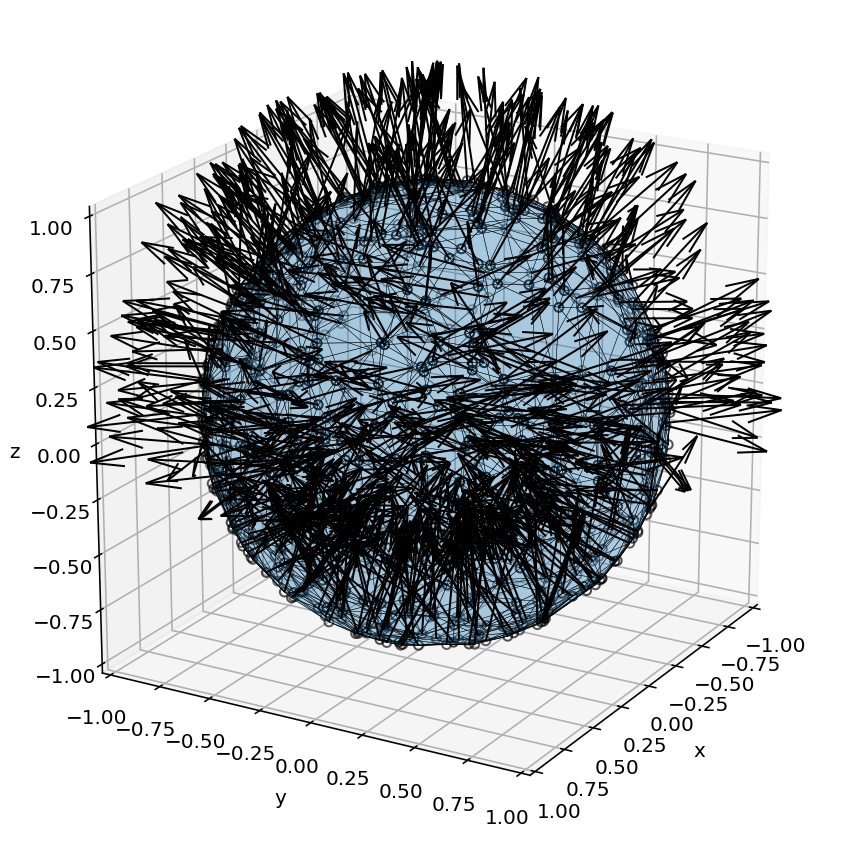

In [9]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(*xyz.T, ec='k', c='None')
ax.quiver(*xyz.T, *n.T, length=0.5, lw=1, color='k')
hull_triangle_coords = hull.points[hull.simplices]
triangles = Poly3DCollection(hull_triangle_coords, ec='k', lw=0.2, alpha=0.2)
ax.add_collection3d(triangles)
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1))
ax.view_init(20, 30)
ax.set_box_aspect([1, 1, 1])
ax = set_axes_equal(ax)
fig.tight_layout();

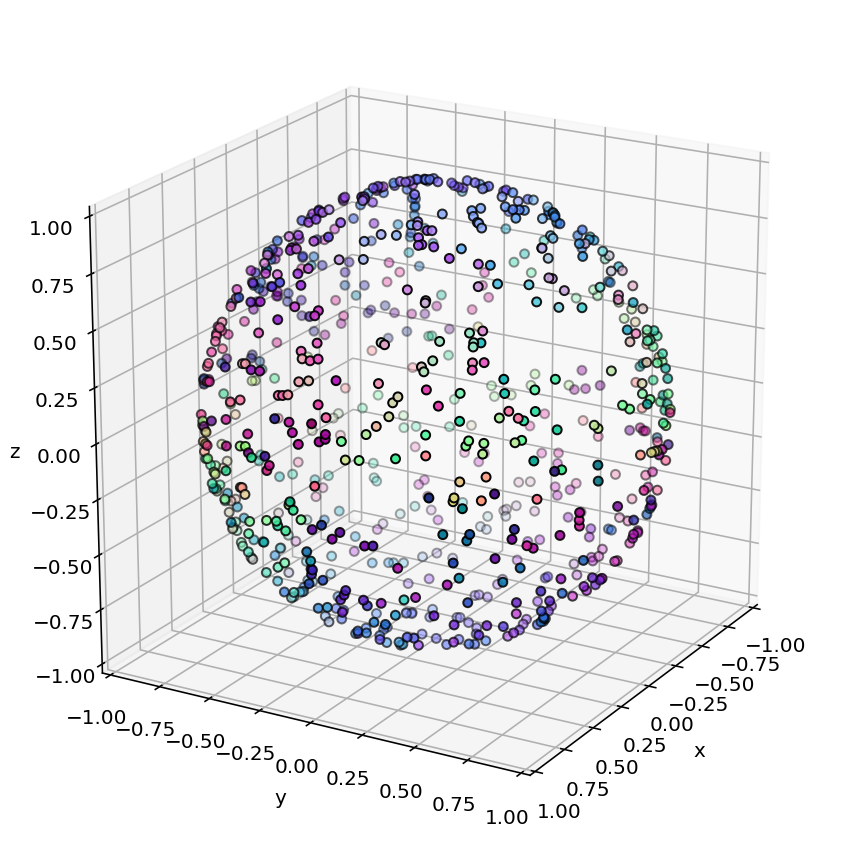

In [10]:
c = normals_to_rgb(n)

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection ='3d')
s = ax.scatter(*xyz.T, ec='k', color=c)
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1))
ax.view_init(20, 30)
ax.set_box_aspect([1, 1, 1])
ax = set_axes_equal(ax)
fig.tight_layout();

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


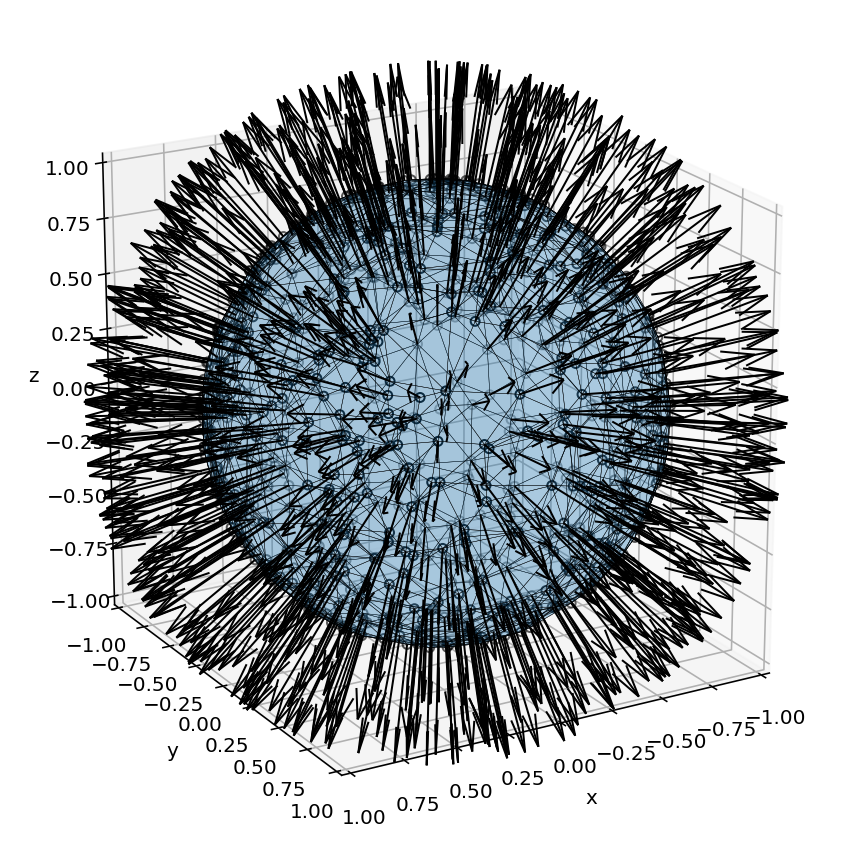

In [11]:
n = estimate_normals(xyz)
c = normals_to_rgb(n)

fig = plt.figure(figsize=(6, 6))
ax = plt.axes(projection ='3d')
ax.scatter(*xyz.T, ec='k', c='None')
ax.quiver(*xyz.T, *n.T, length=0.5, lw=1, color='k')
hull_triangle_coords = hull.points[hull.simplices]
triangles = Poly3DCollection(hull_triangle_coords, ec='k', lw=0.2, alpha=0.2)
ax.add_collection3d(triangles)
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1))
ax.view_init(20, 60)
ax.set_box_aspect([1, 1, 1])
ax = set_axes_equal(ax)
fig.tight_layout();

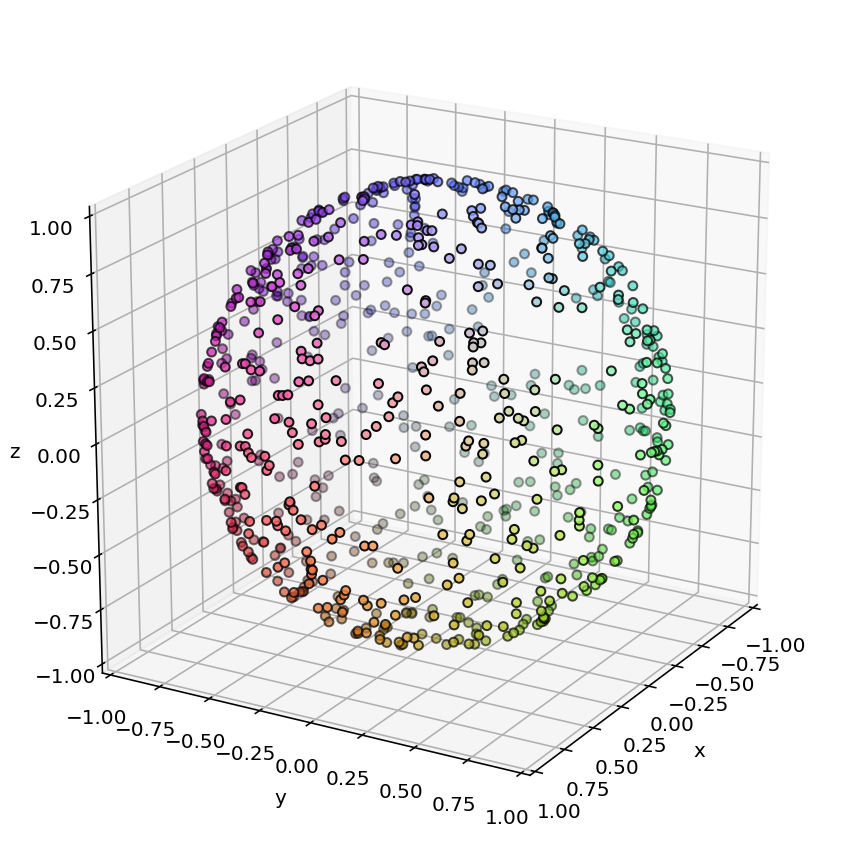

In [12]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection ='3d')
s = ax.scatter(*xyz.T, ec='k', color=c)
ax.set(xlabel='x', ylabel='y', zlabel='z',
       xlim=(-1, 1), ylim=(-1, 1), zlim=(-1, 1))
ax.view_init(20, 30)
ax.set_box_aspect([1, 1, 1])
ax = set_axes_equal(ax)
fig.tight_layout();